# PART 1 - PREPROCESSING

In [3]:
import decimal
import json
import os
import re
import requests
import string
import sys
import warnings

sys.path.append('..')

from bs4 import BeautifulSoup
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
import nltk
import numpy as np
from neo4j import GraphDatabase
import pandas as pd
import psycopg2
from pymongo import MongoClient
from rake_nltk import Rake
import seaborn as sns
from tqdm import tqdm

In [4]:
warnings.filterwarnings('ignore')
load_dotenv(find_dotenv()) # To retrieve the credentials from a .env file -- Environment Variables

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## STEP 1-2: Neo 4J - Retrieve Technologies and Keywords

In [10]:
# OUTPUT: Keywords per technology

In [7]:
graphdb1= GraphDatabase.driver(uri="bolt://localhost:7687",auth=("neo4j","DSC202_Final_Project"))
graphdb2 = GraphDatabase.driver(uri="bolt://awesome-hw.sdsc.edu",auth=("neo4j","b!Q{@q9m"))

In [ ]:

#---(1) Find list of technologies with expertise ------------------------------
def neo4j_find_technologies_w_exp(graphdb):
    
    #Initialize empty tech list
    tech_list =[]
    
    #Initialize session in neo4j and run query
    #Query: finds technologies and the corresponding number of companies with expertise. Ranked in desc order.
    session = graphdb.session()
    q1 = "match p= (a:technology)-[r:hasExpertiseIn]-(b) return a.name AS Technology, count(p) AS Degree order by Degree desc"
    nodes = session.run(q1)
    
    #Populate tech list 
    for node in nodes:
        tech = node.value('Technology').lower()
        tech_list.append(tech)
    
    #Close session and return tech list
    session.close()
    
    return tech_list


#---(2) Search ACM Ontology for keywords---------------------------------------
def neo4j_get_ontology_keywords(graphdb,technology):
    
    #Initialize keyword list and set initial keyword to be the name of the technology itself. 
    kw_list =[technology.lower()]
    
    #Initialize session in neo4j and run query
    #Query: retrieve up to 6 levels of the keyword ontology when looking up a particular technology. Case insensitive search using neo4j regexp
    session = graphdb.session()
    q2="MATCH p=(j:skos__Concept)-[r:skos__narrower*..6]->(b) WHERE j.skos__prefLabel =~ '(?i)" + technology + "' RETURN b.skos__prefLabel AS keyword"
    nodes = session.run(q2)
    
    #Populate keyword list (all lower case)
    for node in nodes:
        keyword = node.value('keyword').lower()
        kw_list.append(keyword)
        
    #Close session and return tech list
    session.close()

    return kw_list

In [10]:
# Run function to get tech list
tech_list = neo4j_find_technologies_w_exp(graphdb2)

In [13]:
df=pd.DataFrame(tech_list, columns=['Technology'])
df['Keywords']=None

count=0
for i in range(len(df.index)):
    
    try:
        technology = df.loc[i].at['Technology']
        kw_list = neo4j_get_ontology_keywords(graphdb1,technology)
        df.loc[i].at['Keywords'] = kw_list
    except Exception:
        df.loc[i].at['Keywords'] = df.loc[i].at['Technology']
        count+=1
print(df)

In [284]:
df.to_csv('kw_universe.csv', index=False)

## STEP 3: PostGres - Look for Keywords on Postgress

We'll look for the different keywords in the texts of the datasets: __patents__, __awards__, __papers__

__Connections__

In [17]:
# 1. Stablish Connections To Postgres DBs

# Connection UCSD DSC 202
conn_dsc202 = psycopg2.connect(
    host=os.environ.get('HOST_DSC202'),
    user=os.environ.get('USER_DSC202'),
    database=os.environ.get('DATABASE_DSC202'),
    password=os.environ.get('PASSWORD_DSC202')
)


# Connection AWS Group Project
conn_aws = psycopg2.connect(
    host=os.environ.get('HOST_AWS'),
    user=os.environ.get('USER_AWS'),
    database=os.environ.get('DATABASE_AWS'),
    password=os.environ.get('PASSWORD_AWS')
)

__KeyWord Treatment__

In [18]:
# Keyword universe from Step 1
kw_universe = pd.read_csv('../data/kw_universe.csv').head(50)

In [19]:
# Clean Keywords
clean_keywords = []
searched_keywords = []
for i, row in kw_universe.iterrows():
    kw = row['Keywords']
    try:
        kw_list = eval(kw)
        for k in kw_list:
            searched_keywords.append(k)
    except:
        clean_keywords.append(np.nan)
        continue    
    clean_keywords.append(kw_list)
    
kw_universe['Keywords'] = pd.Series(clean_keywords)
kw_universe.columns = [c.lower() for c in kw_universe.columns]
kw_universe = kw_universe.dropna(how='any')
searched_keywords = list(set(searched_keywords))

__Text Extraction__

In [24]:
# Reading texts from datasets - With extra columns
#query_text_papers = open('../sql/query_text_papers.sql', 'r').read()
#query_text_patents = open('../sql/query_text_patents.sql', 'r').read()
#query_text_awards = open('../sql/query_text_awards.sql', 'r').read()

In [13]:
# Reading texts from datasets # With extra columns

query_text_papers = '''
    select "Publication ID" publication_id, 
       "Title" title,
       "Abstract" abstract,
       array_length(string_to_array("Authors", ';'), 1)  num_authors,
       "PubYear" pub_year
    from papersdb
'''

query_text_patent = '''
    SELECT patentid,
       title,
       abstract, 
       coalesce(jsonb_array_length(cite -> 'backwardReferences'), 0) num_backward,
       coalesce(jsonb_array_length(cite -> 'forwardReferencesOrig'), 0) num_forward     
    FROM patentdb
'''

query_text_awards = '''
    SELECT "RecordID" record_id,
           "Award Title" title,
           "abstract" abstract,
           "Award Year" award_year,
           "Award Amount" award_amount
    FROM sbir_award_data
'''

In [ ]:
%%time
# Load id data, title and abstract - also, ordering columns
text_papers = pd.read_sql(query_text_papers, con=conn_aws)
text_patents = pd.read_sql(query_text_patents, con=conn_dsc202)
text_awards = pd.read_sql(query_text_awards, con=conn_dsc202)

In [34]:
# Filter the registries with abstract with too large lengths to avoid complex searches
max_words = 3000
text_patents = text_patents[text_patents['abstract'].str.split().str.len() < max_words]
text_papers = text_papers[text_papers['abstract'].str.split().str.len() < max_words]
text_awards = text_awards[text_awards['abstract'].str.split().str.len() < max_words]

In [35]:
text_papers.to_csv('../data/text_papers.csv', index=False)
text_patents.to_csv('../data/text_patents.csv', index=False)
text_awards.to_csv('../data/text_awards.csv', index=False)

__Keyword Detection__

In [88]:
def get_kw_data_in_df(df, searched_keywords):
    '''
    Looks for the existence of keywords in a text
    '''
    chars_to_delete = string.punctuation + string.digits + '\n≥'

    found_kw_data = []
    id_col = list(df)[0]

    n = len(df)
    for i, row in tqdm(df.iterrows(), total=n, position=0, leave=True):
        try:
            id_row = row[id_col]
            total_text = str(row['abstract']) + ' ' + str(row['title'])
            total_text = total_text.lower()
            total_text = total_text.replace('\n', ' ')

            clean_text = re.sub(f'[{chars_to_delete}]',  ' ', total_text)
            clean_text = re.sub(' +', ' ', clean_text)

            kw_found = [kw for kw in searched_keywords if kw in clean_text]

            if len(kw_found)>0:
                kw_data = {
                    id_col: id_row,
                    'keywords': kw_found
                }
                found_kw_data.append(kw_data)
        except:
            pass
    return pd.DataFrame(found_kw_data)

In [40]:
# Restore the data p../data/to run all the keyword detector
text_papers = pd.read_csv('../data/text_papers.csv')
text_patents = pd.read_csv('../data/text_patents.csv')
text_awards = pd.read_csv('../data/text_awards.csv')

In [41]:
text_awards['record_id'] = text_awards['record_id'].astype(str)

In [90]:
# Retrieve the keywords found in the texts of each type of documents
awards_keywords = get_kw_data_in_df(text_awards.sample(2000, random_state=2), searched_keywords)
patents_keywords = get_kw_data_in_df(text_patents.sample(2000, random_state=2), searched_keywords)
papers_keywords = get_kw_data_in_df(text_papers.sample(2000, random_state=2), searched_keywords)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 852.89it/s]


## STEP 4: Python2Neo4J - Upload the edges and relationships

In [92]:
#from src.neo_utils import (upload_nodes_df_to_neo4j, 
#                           upload_edges_df_to_neo4j, 
#                           get_df_relationship)

In [93]:
################# NEO4J - UPLOADING DATA #################

def upload_nodes_df_to_neo4j(label:str, data:pd.DataFrame, session, features=[]):
    '''
    Uploads the elements of a DataFrame as nodes. 
    It will upload all the content as attributes if not specified.
    
    Parameters
    ----------
        label (str): Name of the label node
        data (pd.DataFrame): Data with the nodes to be uploaded
        session (neo4j connector): Connector or cursor from the neo4j library
        features (list): Columns to upload (all if not specified)
    '''
    
    df = data[features].copy() if features != [] else data.copy()
    
    querys = []
    ln = len(df)
    for i, row in tqdm(df.iterrows(), total=ln, position=0, leave=True):   
#    for i, row in df.iterrows():
        drow=row.to_dict()
        query = f'create ({label[0].lower()}:{label} {{'

        n = len(drow)
        # Creating the query
        for i, key in enumerate(drow):
            val = drow[key]
            if isinstance(val, str):
                qry = f"{key}:'{val}'"
            elif isinstance(val, int) or isinstance(val, float):
                qry = f"{key}:{val}"
            else:
                qry = f"{key}:'{val}'"
            query += f'{qry}, ' if i < n-1 else qry 
        query += '})'
        #print(query)
        session.run(query)
        querys.append(query)   

        
def upload_edges_df_to_neo4j(label_a, label_b, label_rel, data, session):
    '''
    Uploads the relationship betweern elements as edges. 
    
    Parameters
    ----------
        label_a (str): Label of the origin node
        label_b (str): Lbel of the end node
        label_rel (str): Label of the relationship
        data (pd.DataFrame): Data with the relationships to be uploaded
        session (neo4j connector): Connector or cursor from the neo4j library
    '''
    
    col_a, col_b = list(data)
    la = label_a[0].lower()
    lb = label_b[0].lower()
    lr = label_rel[0].lower()
    df = data.copy()
    
    querys = []
    ln = len(df)
    for i, row in tqdm(df.iterrows(), total=ln, position=0, leave=True):   
#    for i, row in df.iterrows():
    
        drow=row.to_dict()

        n = len(drow)
        keys = list(drow)

        query = f'''
        match ({la}:{label_a}), ({lb}:{label_b}) 
        where {la}.{col_a} = '{drow[col_a]}' AND {lb}.{col_b} = '{drow[col_b]}'
        create ({la})-[{lr}:{label_rel}]->({lb})
        '''
        #print(query)
        session.run(query)

    querys.append(query)         
        

def get_df_relationship(df):
    '''
    Creates a dataframe unnesting a column of type str[]
    
    Parameters
    ----------
        df (pd.DataFrame): DataFrame with relationships
    
    Returns
    -------
        df_rels (pd.DataFrame): DataFrame with the relationships unnested
    '''
    
    rels = []
    id_col, agg_col = list(df)
    for i, row in df.iterrows():
        for elm in row[agg_col]:
            id_val = row[id_col]
            rels.append([id_val, elm])
    df_rels = pd.DataFrame(rels, columns=[id_col, agg_col])
    return df_rels        

In [97]:
# Data and relationships to be uploaded to Neo4J (Cleaning to upload only the documents with keybo)
text_awards_data = text_awards[text_awards['record_id'].isin(awards_keywords['record_id'])][['record_id', 'award_year', 'award_amount']]
text_patents_data = text_patents[text_patents['patentid'].isin(patents_keywords['patentid'])][['patentid', 'num_backward', 'num_forward']]
text_papers_data = text_papers[text_papers['publication_id'].isin(papers_keywords['publication_id'])][['publication_id', 'num_authors', 'pub_year']]

In [101]:
###### Import data into neo4j ##########33
from neo4j import GraphDatabase

neo4j_uri = 'bolt://localhost:7687'
pwd = 'password'
usr = 'neo4j'

# Connection UCSD DSC 202
conn_neo4j = GraphDatabase.driver(
    uri=neo4j_uri, 
    auth=(usr, 
          pwd)
)
session_neo4j = conn_neo4j.session()

In [102]:
keywords_data = pd.DataFrame(searched_keywords, columns=['keywords'])
technology_data = pd.DataFrame(kw_universe['technology'])

In [103]:
# Extracting the relationships (each rel per row)
rels_tech = get_df_relationship(kw_universe)
rels_papers = get_df_relationship(papers_keywords)
rels_patents = get_df_relationship(patents_keywords)
rels_awards = get_df_relationship(awards_keywords)

In [107]:
# UPLOADING NODES

# Upload Nodes: Awards, Papers, Patents
upload_nodes_df_to_neo4j(label='AWARDS', data=text_awards_data, session=session_neo4j)
upload_nodes_df_to_neo4j(label='PAPERS', data=text_papers_data, session=session_neo4j)
upload_nodes_df_to_neo4j(label='PATENTS', data=text_patents_data, session=session_neo4j)

# Upload Nodes: Keywords, Technology
upload_nodes_df_to_neo4j(label='KEYWORDS', data=keywords_data, session=session_neo4j)
upload_nodes_df_to_neo4j(label='TECHNOLOGY', data=technology_data, session=session_neo4j)

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 247.58it/s]


In [108]:
# UPLOADING EDGES

# Upload Edges: Awards, Papers, Patents - Keywords
upload_edges_df_to_neo4j(label_a='AWARDS', label_b='KEYWORDS', label_rel='HAS_KEYWORD', data=rels_awards, session=session_neo4j)
upload_edges_df_to_neo4j(label_a='PAPERS', label_b='KEYWORDS', label_rel='HAS_KEYWORD', data=rels_papers, session=session_neo4j)
upload_edges_df_to_neo4j(label_a='PATENTS', label_b='KEYWORDS', label_rel='HAS_KEYWORD', data=rels_patents, session=session_neo4j)

# Upload Nodes: Technology - Keywords
upload_edges_df_to_neo4j(label_a='TECHNOLOGY', label_b='KEYWORDS', label_rel='HAS_KEYWORD', data=rels_tech, session=session_neo4j)

100%|███████████████████████████████████████████████████████████████████████████████| 266/266 [00:01<00:00, 144.73it/s]


## STEP 5: Neo4J - Get Best Ids per Document 
This is used in the Reporting Part

In [116]:
technology = 'machine learning'

In [152]:
query_neo_patents = f'''
    MATCH (p:PATENTS)-[h:HAS_KEYWORD]->(k:KEYWORDS)<-[m:HAS_KEYWORD]-(t:TECHNOLOGY)
    WHERE t.technology='{technology}'
    WITH p, h, k, m, t ORDER BY p.num_backward DESC, p.num_forward DESC
    RETURN p//, h, k, m, t
    LIMIT 10
'''

In [153]:
query_neo_papers = f'''
    MATCH (p:PAPERS)-[h:HAS_KEYWORD]->(k:KEYWORDS)<-[m:HAS_KEYWORD]-(t:TECHNOLOGY)
    WHERE t.technology='{technology}'
    WITH p, h, k, m, t ORDER BY p.pub_year DESC, p.num_authors DESC
    RETURN p//, h, k, m, t
    LIMIT 10
'''

In [154]:
query_neo_award = f'''
    MATCH (p:AWARDS)-[h:HAS_KEYWORD]->(k:KEYWORDS)<-[m:HAS_KEYWORD]-(t:TECHNOLOGY)
    WHERE t.technology='{technology}'
    WITH p, h, k, m, t ORDER BY p.award_year DESC, p.award_amount DESC
    RETURN p//, h, k, m, t
    LIMIT 10
'''

In [239]:
def get_selected_ids(query, session, id_col=''):
    result = session_neo4j.run(query).data()
    return [list(row.values())[0][id_col] for row in result]

In [247]:
chosen_ids_awards = get_selected_ids(query_neo_award, session_neo4j, id_col='record_id')
chosen_ids_papers = get_selected_ids(query_neo_papers, session_neo4j, id_col='publication_id')
chosen_ids_patents = get_selected_ids(query_neo_patents, session_neo4j, id_col='patentid')

## STEP 6: Extract information from Postgres for the report

In [112]:
chosen_ids_awards = awards_keywords['record_id'].to_list()
chosen_ids_papers = papers_keywords['publication_id'].to_list()
chosen_ids_patents = patents_keywords['patentid'].to_list()

In [120]:
query_papers = f'''
    WITH
    papers as (
        SELECT "Rank" rank
            , "Publication ID" publication_id
            , "DOI" doi
            , "PMID" pmid
            , "PMCID" pmcid
            , "Title" title
            , "Abstract" abstract
            , "Acknowledgements" acknowledgements
            , "Source title" source_title
            , "Publisher" publisher
            , "MeSH terms" mesh_terms
            , "Publication Date" publication_date
            , "PubYear" pub_year
            , "Volume" volume
            , "Issue" issue
            , "Open Access" open_access
            , "Publication Type" publication_type
            , "Authors" authors
            , "Authors Affiliations" authors_affiliations
            , "Research Organizations - standardized" research_organizations
            , "City of Research organization" city_of_research
            , "State of Research organization" state_of_research
            , "Country of Research organization" country_of_research
            , "Funder" funder
            , "UIDs of supporting grants" uids_supporting_grants
            , "Times cited" times_cited
            , "Recent citations" recent_citations
            , "Dimensions URL" dimensions_url
            , "Source Linkout" source_linkout
            , "Fields of Research (ANZSRC 2020)" fields_of_research
            , "RCDC Categories" rcdc_categories
            , string_to_array("Authors", '; ') authors_array
        FROM papersdb
    )
    , AUTHORS AS (
        SELECT publication_id
             , unnest(authors_array) authors
        FROM papers
    )
    , COUNTER_PUBLICATIONS AS (
        SELECT authors
             , count(1) num_publications
        FROM AUTHORS
        GROUP BY 1
    )
    , PUBLICATION_COUNTER AS (
        SELECT A.publication_id, A.authors, B.num_publications
        FROM AUTHORS A
        LEFT JOIN COUNTER_PUBLICATIONS B ON A.authors = B.authors
    )
    , STATS_CITATIONS AS (
        SELECT publication_id
             , MAX(num_publications) max_publications_per_author
             , round(AVG(num_publications), 2) avg_publications_per_author
             , SUM(num_publications) total_publications_authors
             , COUNT(num_publications) num_authors
        FROM PUBLICATION_COUNTER
        GROUP BY 1
    )
    , DATA_PAPERS AS (
        SELECT A.publication_id
             , A.rank
             , A.title
             , case when length(A.abstract) < 3000 then A.abstract else substr(A.abstract, 1, 3000) end abstract
             , A.publisher
             , A.mesh_terms
             , A.publication_date
             , A.open_access
             , A.authors
             , B.avg_publications_per_author
             , B.total_publications_authors
             , B.max_publications_per_author
             , B.num_authors
             , A.research_organizations
             , A.dimensions_url
        FROM PAPERS A
        LEFT JOIN STATS_CITATIONS B ON A.publication_id=B.publication_id
    )
    SELECT *
    FROM DATA_PAPERS
    WHERE PUBLICATION_ID IN {tuple(chosen_ids_papers)}
--    LIMIT 300
'''

In [121]:
query_awards = f'''
    WITH AWARDS AS (
        SELECT "RecordID" record_id
               , "Company" company
               , "Award Title" award_title
               , "Agency" agency
               , "Branch" branch
               , "Phase" phase
               , TO_DATE("Proposal Award Date", 'MM/DD/YYYY')::timestamp proposal_date
               , TO_DATE("Contract End Date", 'MM/DD/YYYY')::timestamp contract_end_date
               , "Award Year" award_year
               , replace("Award Amount",',','')::float award_amount
               , "Number Employees" num_employees
               , "City" city
               , case when length("abstract") < 3000 then "abstract" else substr("abstract", 1, 3000) end abstract
               , "Contact Name" contact_name
               , "Contact Phone" contact_phone
               , "Contact Email" contact_email
        FROM sbir_award_data
    )
    , COMPANY_DATA AS (
        SELECT company
             , count(1) num_awards_company
             , max(award_amount) max_award_amount_company
             , sum(award_amount) total_award_amount_company
             , round(avg(award_amount)) avg_award_amount_company
        FROM AWARDS
        GROUP BY 1
    )
    , DATA_AWARDS AS (
        SELECT A.record_id
             , A.award_title
             , A.abstract
             , A.agency
             , A.phase
             , A.num_employees
             , A.company
             , B.num_awards_company
             , A.award_amount
             , B.max_award_amount_company
             , B.total_award_amount_company
             , B.avg_award_amount_company
             , A.proposal_date::date proposal_date
             , A.contract_end_date::date contract_end_date
             , abs(extract(days from A.contract_end_date - A.proposal_date)) award_days_duration
             , A.contact_name
             , A.contact_phone
             , A.contact_email
        FROM AWARDS A
        LEFT JOIN COMPANY_DATA B ON A.company = B.company
    )
    SELECT *
    FROM DATA_AWARDS
    WHERE record_id IN {tuple(chosen_ids_awards)}
--    LIMIT 300
'''

In [122]:
query_patents = f'''
    WITH
    EVENT_DATASET AS (
        WITH
        TIME_EVENTS AS (
            SELECT p.patentid
                 , arr.value->>'title' as event
                 , arr.value->>'date' as date
                 , arr.value
            FROM patentdb p, jsonb_array_elements(time_events) as arr
            WHERE jsonb_typeof(time_events) = 'array'
        )
        , RANKED_EVENTS AS (
            SELECT
                *
                , row_number() over (partition by patentid order by date asc) rown_asc
                , row_number() over (partition by patentid order by date desc) rown_desc
            FROM TIME_EVENTS
        )
        , AGG_REGISTRIES AS (
            SELECT patentid
        -- Events: publication, external-priority, reassignment, priority,
        -- filed, legal-status, litigation, granted
                 , sum(CASE WHEN event = 'publication' then 1 else 0 end) num_publications
                 , sum(CASE WHEN event = 'granted' then 1 else 0 end) num_grants
                 , sum(CASE WHEN event = 'litigation' then 1 else 0 end) num_litigations
                 , min(CASE WHEN event = 'publication' then date end) first_publication
                 , max(CASE WHEN event = 'publication' then date end) last_publication
                 , min(CASE WHEN event = 'granted' then date end) first_grant
                 , max(CASE WHEN event = 'granted' then date end) last_grant
            FROM TIME_EVENTS
            GROUP BY 1
        )
        , FIRST_REGISTRY AS (
            SELECT *
            FROM RANKED_EVENTS
            WHERE rown_asc = 1
            --    AND  patentid='AU1769501A'
        )
        , LAST_REGISTRY AS (
            SELECT *
            FROM RANKED_EVENTS
            WHERE rown_desc = 1
            --    AND  patentid='AU1769501A'
        )
        SELECT ar.*
             , fr.event first_status
             , fr.date first_status_date
             , lr.event last_status
             , lr.date last_status_date
             --, round(abs(extract(days from ar.first_publication::timestamp - fr.date::timestamp))/30.4) months_from_first_activity_to_first_publication
        FROM AGG_REGISTRIES ar
        LEFT JOIN FIRST_REGISTRY fr ON ar.patentid=fr.patentid
        LEFT JOIN LAST_REGISTRY lr ON ar.patentid=lr.patentid
    )
    , INVENTOR_DATASET AS (
        WITH
        INVENTORS AS (
            SELECT patentid
                 , unnest(inventor_name) inventor
            FROM patentdb
        )
        , COUNTER_PATENTS AS (
            SELECT inventor
                 , count(1) num_patents
            FROM INVENTORS
            GROUP BY 1
        )
        , PATENT_COUNTER AS (
            SELECT A.patentid, A.inventor, B.num_patents
            FROM INVENTORS A
            LEFT JOIN COUNTER_PATENTS B ON A.inventor = B.inventor
        )
        , STATS_INVENTIONS AS (
            SELECT patentid
                 , MAX(num_patents) max_patents_per_inventor
                 , round(AVG(num_patents), 2) avg_patents_per_inventor
                 , SUM(num_patents) total_patents_inventors
                 , COUNT(num_patents) num_inventors
            FROM PATENT_COUNTER
            GROUP BY 1
        )
        SELECT *
        FROM STATS_INVENTIONS
    )
    , DATA_PATENTS AS (
        SELECT A.patentid
             , A.inventor_name
             , A.assignee_name_origin
             , A.assignee_name_current
             , A.countrycode
             , A.title
             , CASE WHEN length(A.abstract) < 3000 THEN A.abstract ELSE substr(A.abstract, 1, 3000) END abstract

             , B.num_publications
             , B.num_grants
             , B.num_litigations
             , B.first_publication
             , B.last_publication
             , B.first_grant
             , B.last_grant
             , B.first_status
             , B.first_status_date
             , B.last_status
             , B.last_status_date

             , C.max_patents_per_inventor
             , C.avg_patents_per_inventor
             , C.total_patents_inventors
             , C.num_inventors
        FROM patentdb A
        LEFT JOIN  EVENT_DATASET B ON A.patentid = B.patentid
        LEFT JOIN INVENTOR_DATASET C ON A.patentid = C.patentid
    )
    SELECT *
    FROM DATA_PATENTS
    WHERE patentid IN {tuple(chosen_ids_patents)}
--    LIMIT 300
'''

In [123]:
%%time
data_papers = pd.read_sql(query_papers, con=conn_aws)
data_awards = pd.read_sql(query_awards, con=conn_dsc202)
data_patents = pd.read_sql(query_patents, con=conn_dsc202)

CPU times: total: 297 ms
Wall time: 17.6 s


In [320]:
data_papers.to_csv('../data/data_papers.csv', index=False)
data_patents.to_csv('../data/data_patents.csv', index=False)
data_awards.to_csv('../data/data_awards.csv', index=False)

## STEP 7: MongoDB Loading Data

In [128]:
# Establish connection
client = MongoClient("mongodb://localhost:27017/")

# Select or create database
#db = client["DSC202_Final_Project"]
db = client["DB1"]

# Select or create collections
collection_searches = db["Wikipedia Searches"]
collection_page     = db["Wikipedia Pages"]

In [129]:
#---(1) Use Wikipedia API to search for a term and retrieve results -------------

def wiki_searches(subject):
    # API Params
    url = 'https://en.wikipedia.org/w/api.php'
    params = {
        'action': 'query',
        'format': 'json',
        'list':'search',
        'utf8':1,
        'srsearch':subject
    }
     
    response = requests.get(url, params=params)
    search_data = response.json()
    
    ## Print list of search matches in a dataframe
    # df = pd.DataFrame(columns=['Search Matches'])
    # for i in range(len((data['query']['search']))):
    #     df.loc[i]=data['query']['search'][i]['title']
    # print(df)
        
    return search_data

#---(2) Use Wikipedia API to get page HTML + Abstract + Infobox ---------------------

def wiki_request_page(subject,group):
    
    # API Params
    url = 'https://en.wikipedia.org/w/api.php'
    params = {
        'action': 'parse',
        'page': subject,
        'format': 'json',
        'prop':'text',
        'redirects':''
    }
     
    response = requests.get(url, params=params)
    page_data = response.json()

    #Create copy of 'title' at the top level of json response
    # Rename dictionary key from 'text' to 'HTML' for convenience
    page_data['Title']=page_data['parse']['title']
    page_data['parse']['html'] = page_data['parse'].pop('text')

    # Parse html data using Beautiful Soup html parser
    soup = BeautifulSoup(page_data['parse']['html']['*'],'html.parser')    
    
    #---ABSTRACT---
    # Retrieve abstract from soup
    # Go to the table of contents for the wikipedia page and find previous <p> tags (which are are the abstract paragraphs)
    
    # A try except block is used in case this step fails e.g. in case there are pages with no abstracts. 
    page_data['Grouping'] = group
    try: 
        toc = soup.find('div',{'id':'toc'})
        abstract_paras=toc.find_previous_siblings("p")
        
        # Sometimes the abstract <p> tags are one level up so this is needed in case the code above does not pick it up. 
        if len(abstract_paras) ==0:
            abstract_paras=toc.parent.find_previous_siblings("p")
    
        # Get the text from these each abstract <p> tag
        abstract_text=[]
        for i in range(len(abstract_paras)):
            text = abstract_paras[i].get_text()
            text = text.replace("\n"," ")
            abstract_text.append(text)
 
        # Paragraphs are retrieved in reverse order so they need the orderering to be changed
        # All paragraphs are joined together to form one string
        abstract_text.reverse()
        abstract_text =' '.join(abstract_text)
    
        # Append the page_data variable that will go into MongoDB to include the abstract
        page_data['parse']['abstract'] = abstract_text

    except: 
        pass


     #---Infobox---
    # Retrieve infobox from soup
    # Go to the infobox, find all <th> header tags and sibling <td> data tags
    
    try:
        infobox = soup.find('table',{'class':'infobox vcard'})

        th_tags = infobox.find_all('th')
        
        #Intialize dictionary to populate with keys and values that will be uploaded to MongoDB
        d = {}
        
        #Get text content from th tags and td tags and populate dictionary
        for i in range(len(th_tags)):
            contents=th_tags[i].find_next_siblings("td")[0].get_text(separator=' ')
            labels= th_tags[i].get_text(separator=' ')
            d[labels]=contents
    
        # Merge the new dictionary into page_data. Page data (including API response with html and abstract ) + d (with infobox)
        page_data = {**page_data, **d}
    except:
        pass

    return page_data      
    
    #--------------------------------------------------------------------------
    # If we wanted to get the links from the sidebar
    # try:
    #     infobox = soup.find('table',{'class':'infobox vcard'})
    # except:
    #     infobox = soup.find('table',{'class':'infobox','class':'sidebar'})
        
    # try:
    #     a_tags = infobox.find_all('a', href=True)
    #     links = []
    #     for tag in a_tags:
    #         if not tag.text == '' and 'wiki' in tag['href']:
    #             links.append({'anchor':tag.text, 'href':tag['href']})
    #             df=pd.DataFrame(links)
    #             print(df)
    # except:
    #     pass

#---(3) Loading or opening json file-------------------------------------------

def read_json_file(filename):
    with open(filename) as file:
        file_data = json.load(file)
    return file_data
    

#---(4) Insert data into a table collection------------------------------------

def insert_data(collection, data, subject):
    try:        
        if isinstance(data, list):
            collection.insert_many(data)
        else:
            collection.insert_one(data)
        print ('Records inserted into MongoDB -', collection.name, '[',subject,']')
    except:
        print('Could not insert records into MongoDB')
        
###############################################################################
###-------------------------------------------------------------------------###
###-------------------------------------------------------------------------###
###-------------------------------------------------------------------------###
###############################################################################
#------------------------------------------------------------------------------

In [188]:
universities = '; '.join(data_papers['research_organizations'].to_list()).split('; ')
universities = list(set(universities))

companies = data_awards['company'].drop_duplicates().to_list()
clist = data_patents['assignee_name_current'].to_list()
companies += list(set([item for sublist in clist for item in sublist]))

In [191]:
#Example subject, search and upload all matches into mogodb
#companies=['Apple Inc.','Facebook Inc.', 'Alphabet Inc.']
#universities = ['UCSD','UCLA','Pontificia Universidad Católica del Perú','Imperial College London','MIT', 'UC Berkeley']
# other = searched_keywords

#Combine into one dictionary for use in for loop
input_list={
    'company': companies,
    'university': universities,
    'keywords': searched_keywords
}

# Switches for what functions we want to run and what data we want to retrieve
Run_switch_searches = 0
Run_switch_pages = 1


# For loop uses key-value pair from dictionary to pick up grouping-list combinations. 
# The key is required to pass into the wiki_request_page function to classify records in mongoDB. Otherwise a normal for loop could have been used.
for key, values in input_list.items():
    if(isinstance(values,list)):
        for value in values:
            if Run_switch_searches == 1:
                data1 = wiki_searches(value)
                insert_data(collection_searches, data1, value)
            try:
                if Run_switch_pages ==1:
                    data2 = wiki_request_page(value,key)
                    insert_data(collection_page, data2, value)
            except:
                pass
    else:
        print("values is not in a list")

Records inserted into MongoDB - Wikipedia Pages [ Hittite Microwave Corporation ]
Records inserted into MongoDB - Wikipedia Pages [ Knowledge Industries ]
Records inserted into MongoDB - Wikipedia Pages [ Sparta, Inc. ]
Records inserted into MongoDB - Wikipedia Pages [ Electro Magnetic ]
Records inserted into MongoDB - Wikipedia Pages [ Autodesk Inc. ]
Records inserted into MongoDB - Wikipedia Pages [ Kitware, Inc. ]
Records inserted into MongoDB - Wikipedia Pages [ Technology Service Corporation ]
Records inserted into MongoDB - Wikipedia Pages [ NOA ]
Records inserted into MongoDB - Wikipedia Pages [ Combustion Resources ]
Records inserted into MongoDB - Wikipedia Pages [ XCOR Aerospace ]
Records inserted into MongoDB - Wikipedia Pages [ Paragon Space Development Corporation ]
Records inserted into MongoDB - Wikipedia Pages [ LSA ]
Records inserted into MongoDB - Wikipedia Pages [ Boston Micromachines Corporation ]
Records inserted into MongoDB - Wikipedia Pages [ Immersion Corporati

# PART 2 - REPORTING

In [327]:
import decimal
import json
import os
import re
import requests
import string
import sys
import warnings

sys.path.append('..')

from bs4 import BeautifulSoup
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
import nltk
import numpy as np
from neo4j import GraphDatabase
import pandas as pd
import psycopg2
from pymongo import MongoClient
from rake_nltk import Rake
import seaborn as sns
from tqdm import tqdm

In [328]:
warnings.filterwarnings('ignore')
load_dotenv(find_dotenv())

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [329]:
# 1. Stablish Connections To Postgres DBs

# Connection UCSD DSC 202
conn_dsc202 = psycopg2.connect(
    host=os.environ.get('HOST_DSC202'),
    user=os.environ.get('USER_DSC202'),
    database=os.environ.get('DATABASE_DSC202'),
    password=os.environ.get('PASSWORD_DSC202')
)


# Connection AWS Group Project
conn_aws = psycopg2.connect(
    host=os.environ.get('HOST_AWS'),
    user=os.environ.get('USER_AWS'),
    database=os.environ.get('DATABASE_AWS'),
    password=os.environ.get('PASSWORD_AWS')
)

In [330]:
###### Import data into neo4j ##########33
neo4j_uri = 'bolt://localhost:7687'
pwd = 'password'
usr = 'neo4j'

# Connection UCSD DSC 202
conn_neo4j = GraphDatabase.driver(
    uri=neo4j_uri, 
    auth=(usr, 
          pwd)
)
session_neo4j = conn_neo4j.session()

## Step 1: Select Technology

In [463]:
technology = 'machine learning'

In [464]:
query_neo_patents = f'''
    MATCH (p:PATENTS)-[h:HAS_KEYWORD]->(k:KEYWORDS)<-[m:HAS_KEYWORD]-(t:TECHNOLOGY)
    WHERE t.technology='{technology}'
    WITH p, h, k, m, t ORDER BY p.num_backward DESC, p.num_forward DESC
    RETURN p//, h, k, m, t
    LIMIT 100
'''

query_neo_papers = f'''
    MATCH (p:PAPERS)-[h:HAS_KEYWORD]->(k:KEYWORDS)<-[m:HAS_KEYWORD]-(t:TECHNOLOGY)
    WHERE t.technology='{technology}'
    WITH p, h, k, m, t ORDER BY p.pub_year DESC, p.num_authors DESC
    RETURN p//, h, k, m, t
    LIMIT 100
'''

query_neo_award = f'''
    MATCH (p:AWARDS)-[h:HAS_KEYWORD]->(k:KEYWORDS)<-[m:HAS_KEYWORD]-(t:TECHNOLOGY)
    WHERE t.technology='{technology}'
    WITH p, h, k, m, t ORDER BY p.award_year DESC, p.award_amount DESC
    RETURN p//, h, k, m, t
    LIMIT 100
'''

## Step 5: Find best element ids

In [465]:
def get_selected_ids(query, session, id_col=''):
    result = session_neo4j.run(query).data()
    return [list(row.values())[0][id_col] for row in result]

In [466]:
chosen_ids_awards = get_selected_ids(query_neo_award, session_neo4j, id_col='record_id')
chosen_ids_papers = get_selected_ids(query_neo_papers, session_neo4j, id_col='publication_id')
chosen_ids_patents = get_selected_ids(query_neo_patents, session_neo4j, id_col='patentid')

## Step 6: Retrieve the Postgres data

In [470]:
query_papers = open('../sql/query_papers_data.sql', 'r').read()
query_awards = open('../sql/query_awards_data.sql', 'r').read()
query_patents = open('../sql/query_patents_data.sql', 'r').read()

In [471]:
query_papers = query_papers.replace('CHOSEN_IDS', str(tuple(chosen_ids_papers)))
query_awards = query_awards.replace('CHOSEN_IDS', str(tuple(chosen_ids_awards)))
query_patents = query_patents.replace('CHOSEN_IDS', str(tuple(chosen_ids_patents)))

In [472]:
%%time
data_papers = pd.read_sql(query_papers, con=conn_aws)
data_awards = pd.read_sql(query_awards, con=conn_dsc202)
data_patents = pd.read_sql(query_patents, con=conn_dsc202)

CPU times: total: 62.5 ms
Wall time: 14.1 s


In [480]:
data_awards.head(3)

,record_id,award_title,abstract,agency,phase,num_employees,company,num_awards_company,award_amount,max_award_amount_company,total_award_amount_company,avg_award_amount_company,proposal_date,contract_end_date,award_days_duration,contact_name,contact_phone,contact_email
0,88708,Achieving a High Level of Scalability in Feder...,A federated search engine that is capable of s...,Department of Energy,Phase II,14.0,"Deep Web Technologies, Llc",22,499078.0,749826.0,5791368.0,263244.0,None,None,NaN,Abe Lederman,(505) 672-0007,abe@deepwebtech.com
1,89892,Adaptive Toolkit for Pattern Discovery (ATPD),"This project will design, configure, and demon...",Department of Defense,Phase II,80.0,"KNOWLEDGE BASED SYSTEMS, INC.",253,1749910.0,7433422.0,102220746.0,404035.0,2007-04-05,2011-07-03,1550.0,Donielle Mayer,(979) 260-5274,dmayer@kbsi.com
2,97535,Wireless Fidelity from the Sea (WFFTS),The Navy requires development of enabling tech...,Department of Defense,Phase I,300.0,OCEAN SYSTEMS ENGINEERING CORP.(OSEC),10,18000.0,750000.0,2625896.0,262590.0,2006-05-05,2006-07-31,87.0,NIKKI CARTERETTE,(760) 692-0080,ncarterette@osec.com


In [481]:
data_papers.head(3)

,publication_id,rank,title,abstract,publisher,mesh_terms,publication_date,open_access,authors,avg_publications_per_author,total_publications_authors,max_publications_per_author,num_authors,research_organizations,dimensions_url
0,pub.1152720431,500,Fast rule switching and slow rule updating in ...,"To adapt to a changing world, we must be able ...",eLife,None,2022-11-14,All OA; Gold,"Bouchacourt, Flora; Tafazoli, Sina; Mattar, Ma...",1.40,7.0,3,5,"University of California, San Diego; Princeton...",https://app.dimensions.ai/details/publication/...
1,pub.1152680845,100,Automated Detection of Posterior Vitreous Deta...,Objective To develop automated algorithms for ...,Elsevier,None,2022-11,All OA; Gold,"Li, Alexa L.; Feng, Moira; Wang, Zixi; Baxter,...",3.73,41.0,12,11,"University of California, San Diego",https://app.dimensions.ai/details/publication/...
2,pub.1152356379,500,Combining OCT and OCT-Angiography Longitudinal...,PURPOSE: To use longitudinal optical coherence...,Elsevier,None,2022-10-31,Closed,"Kamalipour, Alireza; Moghimi, Sasan; Khosravi,...",13.15,171.0,32,13,"University of California, San Diego; Universit...",https://app.dimensions.ai/details/publication/...


In [482]:
data_patents.head(3)

,patentid,inventor_name,assignee_name_origin,assignee_name_current,countrycode,title,abstract,num_publications,num_grants,num_litigations,first_publication,last_publication,first_grant,last_grant,first_status,first_status_date,last_status,last_status_date,max_patents_per_inventor,avg_patents_per_inventor,total_patents_inventors,num_inventors
0,JP6592755B1,"[雄一 佐々木, 太一 小井土, 路威 重松]",[ニューラルポケット株式会社],[],"[JP, JP]",,"\nA system, method, and program for more appro...",1,1,0,2019-10-23,2019-10-23,2019-10-23,2019-10-23,priority,2019-04-05,legal-status,2020-04-10,6,5.33,16.0,3
1,US6735703B1,"[Douglas Kilpatrick, Mark Lee Badger, Calvin Ko]",[Networks Associates Technology Inc],[McAfee LLC],"[US, US]",System and method for providing a network host...,\nA real-time sequence-based anomaly detection...,1,1,0,2004-05-11,2004-05-11,2004-05-11,2004-05-11,priority,2000-05-08,legal-status,2020-05-08,2,1.67,5.0,3
2,RU2701843C2,[Владимир Сергеевич Пахомов],[Федеральное государственное казённое военное ...,[],"[RU, RU]",DEVICE FOR SELECTING A VARIANT OF ACCOMPLISHED...,\nFIELD: calculating; counting.\nSUBSTANCE: in...,3,1,0,2019-04-23,2019-10-01,2019-10-01,2019-10-01,priority,2017-10-23,publication,2019-10-01,3,3.00,3.0,1


## Step 7: Retrieve the MongoDB data

In [473]:
# Establish connection
client = MongoClient("mongodb://localhost:27017/")

# Select or create database
#db = client["DSC202_Final_Project"]
db = client["DB1"]


# Select or create collections
collection_searches = db["Wikipedia Searches"]
collection_page     = db["Wikipedia Pages"]


num_elements = 20
universities = '; '.join(data_papers['research_organizations'].to_list()).split('; ')[:num_elements]
universities = list(set(universities))

companies = data_awards['company'].drop_duplicates().head(5).to_list()
clist = data_patents['assignee_name_current'].head(5).to_list()
companies += list(set([item for sublist in clist for item in sublist]))

In [474]:
def get_mongo_info_university(universities):
    df = pd.DataFrame()
    for university in universities:
        cursor = collection_page.find( {'Title':f"{university}"}, 
                                   {'Title': 1,
                                    'Type': 1, 
                                    'Location':1, 
                                    'Endowment': 1, 
                                    'Academic staff':1,
                                    'Total staff':1,
                                    'Undergraduates': 1,
                                    'Postgraduates': 1,
                                    'Nickname':1,
                                    'Mascot': 1,
                                    '_id': 0 } )

        
        df_i =  pd.DataFrame(list(cursor)).fillna("-")
        df = df.append(df_i)
    df = df.drop_duplicates().reset_index()
    return df


def get_mongo_info_companies(companies):
    df = pd.DataFrame()
    for company in companies:
        cursor = collection_page.find( 
            {'Title':f'{company}'}, 
            {
                'Title': 1,
                'Type': 1, 
                'Traded as': 1, 
                'Industry':1,
                'Revenue': 1,
                'Net income': 1,
                'Total assets':1,
                'Number of employees': 1,
                '_id': 0} )

        df_i =  pd.DataFrame(list(cursor)).fillna("-")
        df = df.append(df_i)
    df = df.drop_duplicates().reset_index()
    return df

In [475]:
mongo_universities = get_mongo_info_university(universities)
mongo_companies = get_mongo_info_companies(companies)

## Step 8: Build the Report

In [476]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

**FINAL PROJECT - DSC 202 Data management**

**Technology Studied:		MACHINE LEARNING**


Note: This report contains information about papers, patents and awards associated with Machine Learning





**a) Key Awards in Machine Learning**

,record_id,award_title,abstract,agency,phase,num_employees,company,num_awards_company,award_amount,max_award_amount_company,total_award_amount_company,avg_award_amount_company,proposal_date,contract_end_date,award_days_duration,contact_name,contact_phone,contact_email
0,88708,Achieving a High Level of Scalability in Feder...,A federated search engine that is capable of s...,Department of Energy,Phase II,14.0,"Deep Web Technologies, Llc",22,499078.0,749826.0,5791368.0,263244.0,None,None,NaN,Abe Lederman,(505) 672-0007,abe@deepwebtech.com
1,89892,Adaptive Toolkit for Pattern Discovery (ATPD),"This project will design, configure, and demon...",Department of Defense,Phase II,80.0,"KNOWLEDGE BASED SYSTEMS, INC.",253,1749910.0,7433422.0,102220746.0,404035.0,2007-04-05,2011-07-03,1550.0,Donielle Mayer,(979) 260-5274,dmayer@kbsi.com
2,97535,Wireless Fidelity from the Sea (WFFTS),The Navy requires development of enabling tech...,Department of Defense,Phase I,300.0,OCEAN SYSTEMS ENGINEERING CORP.(OSEC),10,18000.0,750000.0,2625896.0,262590.0,2006-05-05,2006-07-31,87.0,NIKKI CARTERETTE,(760) 692-0080,ncarterette@osec.com
3,107723,Adaptive Context-based Configuration for Model...,Conventional ATRs are trained and configured o...,Department of Defense,Phase I,239.0,"ALPHATECH, INC.",228,100000.0,3290430.0,69918568.0,306660.0,2004-03-18,2005-05-18,426.0,John Barry,(781) 273-3388,jbarry@alphatech.com
4,125458,A System for Accurate Detection of Known and N...,70645 Networks and systems owned by ...,Department of Energy,Phase I,0.0,"Immunet Security Solutions, Incorporated",3,100000.0,100000.0,299924.0,99975.0,None,None,NaN,Umamaheswari Ganapathy,(631) 632-8672,umaganapathy@yahoo.com


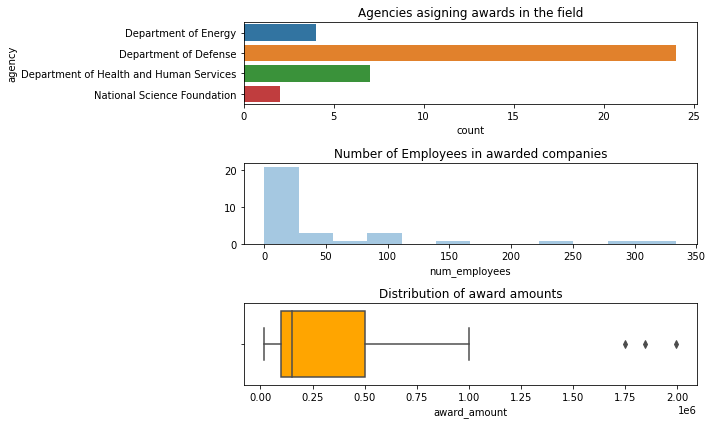

**b) Key Patents in Machine Learning**

,patentid,inventor_name,assignee_name_origin,assignee_name_current,countrycode,title,abstract,num_publications,num_grants,num_litigations,first_publication,last_publication,first_grant,last_grant,first_status,first_status_date,last_status,last_status_date,max_patents_per_inventor,avg_patents_per_inventor,total_patents_inventors,num_inventors
0,JP6592755B1,"[雄一 佐々木, 太一 小井土, 路威 重松]",[ニューラルポケット株式会社],[],"[JP, JP]",,"\nA system, method, and program for more appro...",1,1,0,2019-10-23,2019-10-23,2019-10-23,2019-10-23,priority,2019-04-05,legal-status,2020-04-10,6,5.33,16.0,3
1,US6735703B1,"[Douglas Kilpatrick, Mark Lee Badger, Calvin Ko]",[Networks Associates Technology Inc],[McAfee LLC],"[US, US]",System and method for providing a network host...,\nA real-time sequence-based anomaly detection...,1,1,0,2004-05-11,2004-05-11,2004-05-11,2004-05-11,priority,2000-05-08,legal-status,2020-05-08,2,1.67,5.0,3
2,RU2701843C2,[Владимир Сергеевич Пахомов],[Федеральное государственное казённое военное ...,[],"[RU, RU]",DEVICE FOR SELECTING A VARIANT OF ACCOMPLISHED...,\nFIELD: calculating; counting.\nSUBSTANCE: in...,3,1,0,2019-04-23,2019-10-01,2019-10-01,2019-10-01,priority,2017-10-23,publication,2019-10-01,3,3.00,3.0,1
3,CN101938832A,"[何友, 刘瑜, 王梓有, 衣晓, 邓露]",[中国人民解放军海军航空工程学院],[],"[CN, CN]",Secondary weighted hybrid location method of w...,\nThe invention discloses a division and refin...,1,0,0,2011-01-05,2011-01-05,None,None,filed,2010-09-15,publication,2011-01-05,25,8.80,44.0,5
4,CN107205225B,"[胡博, 陈山枝, 杨翰章, 王雷]",[北京邮电大学],[],"[CN, CN]",A kind of localization method and its device o...,\nThe present invention provides the switching...,2,1,0,2017-09-26,2019-10-11,2019-10-11,2019-10-11,filed,2017-08-03,granted,2019-10-11,53,17.25,69.0,4


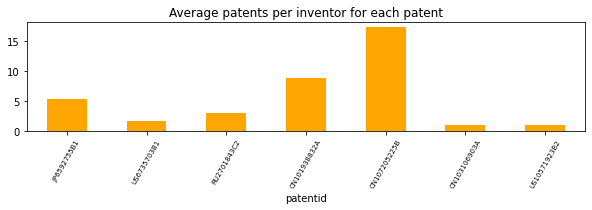

**c) Key Papers in Machine Learning**

,publication_id,rank,title,abstract,publisher,mesh_terms,publication_date,open_access,authors,avg_publications_per_author,total_publications_authors,max_publications_per_author,num_authors,research_organizations,dimensions_url
0,pub.1152720431,500,Fast rule switching and slow rule updating in ...,"To adapt to a changing world, we must be able ...",eLife,None,2022-11-14,All OA; Gold,"Bouchacourt, Flora; Tafazoli, Sina; Mattar, Ma...",1.40,7.0,3,5,"University of California, San Diego; Princeton...",https://app.dimensions.ai/details/publication/...
1,pub.1152680845,100,Automated Detection of Posterior Vitreous Deta...,Objective To develop automated algorithms for ...,Elsevier,None,2022-11,All OA; Gold,"Li, Alexa L.; Feng, Moira; Wang, Zixi; Baxter,...",3.73,41.0,12,11,"University of California, San Diego",https://app.dimensions.ai/details/publication/...
2,pub.1152356379,500,Combining OCT and OCT-Angiography Longitudinal...,PURPOSE: To use longitudinal optical coherence...,Elsevier,None,2022-10-31,Closed,"Kamalipour, Alireza; Moghimi, Sasan; Khosravi,...",13.15,171.0,32,13,"University of California, San Diego; Universit...",https://app.dimensions.ai/details/publication/...
3,pub.1151939313,500,A stakeholder-driven framework for measuring p...,BACKGROUND: People who inject drugs (PWID) hav...,Elsevier,None,2022-10-17,All OA; Green,"Bradley, Heather; Austin, Chelsea; Allen, Sean...",2.32,51.0,11,22,Centers for Disease Control and Prevention; De...,https://app.dimensions.ai/details/publication/...
4,pub.1151703709,500,Archaea Microbiome Dysregulated Genes and Path...,The human microbiome is a vast collection of m...,MDPI,"Adenocarcinoma of Lung; Archaea; Carcinoma, No...",2022-09-30,All OA; Gold,"Uzelac, Matthew; Li, Yuxiang; Chakladar, Jaide...",2.80,14.0,4,5,VA San Diego Healthcare System; University of ...,https://app.dimensions.ai/details/publication/...


Best authors in the field (Hiring prospects): 
['Bouchacourt, Flora', 'Tafazoli, Sina', 'Mattar, Marcelo G', 'Buschman, Timothy J', 'Daw, Nathaniel D']





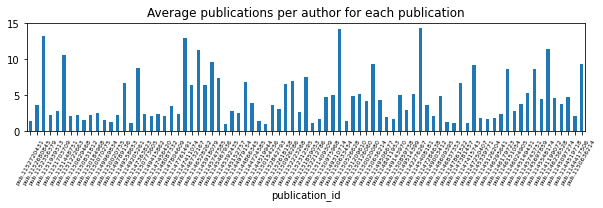

**d) Companies in the field of Machine Learning**

,index


**e) Universities in the field of Machine Learning**

,index,Title,Type,Endowment,Academic staff,Undergraduates,Postgraduates,Location,Nickname,Mascot,Total staff
0,0,West Virginia University,Public land-grant research university,$611.3 million (2020) [2],"1,870","21,086 (Morgantown) [6] \n 1,300 (Keyser) [7] ...","4,263 (Morgantown) [6]","Morgantown , West Virginia , United States 3...",Mountaineers,The Mountaineer,NaN
1,0,Princeton University,Private research university,$37.7 billion (2021) [2],"1,289 [3]","5,422 (Fall 2019) [5]","2,997 (Fall 2019) [5]","Princeton , New Jersey , United States 40°20...",Tigers,The Tiger,"7,300 [4]"
2,0,"University of California, Los Angeles",Public land-grant research university,$5.1 billion (2021) [3],"4,016 [7]","32,121 (Fall 2021) [8]","13,994 (Fall 2021) [8]","Westwood, Los Angeles , California , United ...",Bruins,Joe Bruin Josephine Bruin [12],NaN
3,0,Johns Hopkins University,Private research university,$9.32 billion (2021) [1],NaN,"6,256 (2021) [3] : 33",">20,000 [3] : 35","Baltimore , Maryland , United States 39°19′4...",Blue Jays,Blue Jay,"27,300 [2]"
4,0,Denver Health Medical Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,"University of California, San Diego",Public land-grant research university,$2.6 billion (2021) [2],"10,915 (October 2020) [4]","33,096 (Fall 2022) [5]","9,872 (Fall 2022) [5]","La Jolla , San Diego , California , United ...",Tritons,King Triton [9],NaN
6,0,Washington State Department of Health,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,"University of California, Irvine",Public land-grant research university,$1.3 billion (2021) [2],"5,596 (2019) [5]","30,222 (2019) [6]","5,849 (2019) [6]","Irvine , California , United States 33°38′44...",Anteaters,Peter the Anteater,NaN
8,0,Centers for Disease Control and Prevention,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,Georgia State University,Public research university,170.8 million (2020) [6],"1,586 (Fall 2018) [2]","44,735 (Fall 2018) [10]","6,789 (Fall 2018) [10]","Atlanta, Georgia , U.S. [11] 33°45′13.3″N 8...",Panthers,"Pounce , the blue panther",NaN


**THANKS!**

In [477]:
# BUILDING THE REPORT

print()
printmd(f'**FINAL PROJECT - DSC 202 Data management**')
print()

printmd(f'**Technology Studied:\t\t{technology.upper()}**')
print(f'\nNote: This report contains information about papers, patents and awards associated with {technology.title()}')
print('\n\n')


printmd(f'**a) Key Awards in {technology.title()}**')
display(data_awards.head())
print('\n\n')
fig, ax = plt.subplots(3, 1, figsize=(10, 6))

sns.countplot(data=data_awards, y='agency', ax=ax[0]);
ax[0].set_title(f'Agencies asigning awards in the field');

sns.distplot(data_awards['num_employees'], kde=False, ax=ax[1]);
ax[1].set_title('Number of Employees in awarded companies')

sns.boxplot(data_awards['award_amount'], saturation=1, color='orange', ax=ax[2])
ax[2].set_title('Distribution of award amounts')

plt.tight_layout()
plt.close()
display(fig)



print('\n\n')
printmd(f'**b) Key Patents in {technology.title()}**')
display(data_patents.head())
print('\n\n')

fig2 = plt.figure(figsize=(10, 2))
data_patents.set_index('patentid')['avg_patents_per_inventor'].plot(kind='bar', color='orange')
plt.xticks(rotation=60, size=7)
plt.title('Average patents per inventor for each patent')
display(fig2)
plt.close()


print('\n\n')
printmd(f'**c) Key Papers in {technology.title()}**')
display(data_papers.head())
best_author_papers = '; '.join(data_papers['authors'].head(1).to_list()).split('; ')
print(f'Best authors in the field (Hiring prospects): \n{best_author_papers}')
print('\n\n')

fig3 = plt.figure(figsize=(10, 2))
data_papers.set_index('publication_id')['avg_publications_per_author'].plot(kind='bar')
plt.xticks(rotation=60, size=6)
plt.title('Average publications per author for each publication')
plt.close()
display(fig3)


print('\n\n')
printmd(f'**d) Companies in the field of {technology.title()}**')
display(mongo_companies.head(15))


print('\n\n')
printmd(f'**e) Universities in the field of {technology.title()}**')
display(mongo_universities.head(15))
print('\n\n')


printmd(f'**THANKS!**')